### importação de bibliotecas

In [83]:
import pandas as pd
import numpy as np
import glob 
import matplotlib.pyplot as plt
import urllib
import zipfile
import os
from scipy.fft import rfft, rfftfreq

### Obtenção dos dados

In [43]:
# Download dos arquivos
# urllib.request.urlretrieve('https://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/imbalance.zip', 'imbalance.zip')
# urllib.request.urlretrieve('https://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/normal.zip', 'normal.zip')

# # extração dos arquivos
# with zipfile.ZipFile('imbalance.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')
# with zipfile.ZipFile('normal.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')

# # excluir arquivos .zip
# os.remove('normal.zip')
# os.remove('imbalance.zip')

('normal.zip', <http.client.HTTPMessage at 0x276b567a690>)

### Verificação de dados inválidos

In [2]:
def dataReader(path_names):
    data_n = pd.DataFrame()
    for i in path_names:
        low_data = pd.read_csv(i,header=None)
        data_n = pd.concat([data_n,low_data],ignore_index=True)
    return data_n

In [3]:
def checkNullValues(path_names):
    for file in path_names:
        data = pd.read_csv(file, header=None)
        nullValues = data.isnull().sum()
        if any(nullValues > 0):
            print('CSV file {} has null values'.format(file))

In [4]:
normal_file_names = glob.glob('./data/normal/*.csv')
imbalance6g_file_names = glob.glob('./data/imbalance/6g/*.csv')
imbalance10g_file_names = glob.glob('./data/imbalance/10g/*.csv')
imbalance15g_file_names = glob.glob('./data/imbalance/15g/*.csv')
imbalance20g_file_names = glob.glob('./data/imbalance/20g/*.csv')
imbalance25g_file_names = glob.glob('./data/imbalance/25g/*.csv')
imbalance30g_file_names = glob.glob('./data/imbalance/30g/*.csv')
imbalance35g_file_names = glob.glob('./data/imbalance/35g/*.csv')

checkNullValues(normal_file_names)
checkNullValues(imbalance6g_file_names)
checkNullValues(imbalance10g_file_names)
checkNullValues(imbalance15g_file_names)
checkNullValues(imbalance20g_file_names)
checkNullValues(imbalance25g_file_names)
checkNullValues(imbalance30g_file_names)
checkNullValues(imbalance35g_file_names)

In [5]:
data_normal= dataReader( glob.glob('./data/normal/*.csv'))
data_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12250000 entries, 0 to 12249999
Data columns (total 8 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
dtypes: float64(8)
memory usage: 747.7 MB


In [10]:
def plotSignalSample(dataSample):
    timeAxes = np.arange(0 ,5, 1/50000)
    figure, axis = plt.subplots(8,1, figsize=(12,15),  constrained_layout=True)
    axis[0].plot(timeAxes, dataSample[0])
    axis[1].plot(timeAxes, dataSample[1])
    axis[2].plot(timeAxes, dataSample[2])
    axis[3].plot(timeAxes, dataSample[3])
    axis[4].plot(timeAxes, dataSample[4])
    axis[5].plot(timeAxes, dataSample[5])
    axis[6].plot(timeAxes, dataSample[6])
    axis[7].plot(timeAxes, dataSample[7])
    figure.supxlabel('Seconds')
    figure.supylabel('Voltage')

In [ ]:
normalSample = pd.read_csv('./data/normal/12.288.csv', header=None)
plotSignalSample(normalSample)


In [ ]:
imbalance6gSample = pd.read_csv('./data/imbalance/6g/13.9264.csv', header=None)
plotSignalSample(imbalance6gSample)

Deste gráfico chegamos a 2 conclusões:
- Dados não estão na mesma escala, o que pode enviesar o algoritmo de machine learn.
- Alta taxa de amostragem (50kHz), o que tornará o processo de treinamento muito lento.

In [63]:
def resample(data, sample_target_rate):
    data_resampled = pd.DataFrame()
    period = 5 # seconds
    step = int(len(data)/period / sample_target_rate )
    start_index = 0
    stop_index = step
    for i in range(0, len(data), step):
        data_resampled = pd.concat([data_resampled, data[start_index:stop_index].mean().to_frame().T], axis=0, ignore_index=True)
        start_index += step
        stop_index += step
   
    return data_resampled


In [71]:
target_rate = 1000
SAMPLE_RATE = 50000 # taxa de amostragem original dos dados
normalSampleResampled = resample(normalSample, target_rate)

Text(0, 0.5, 'Voltage')

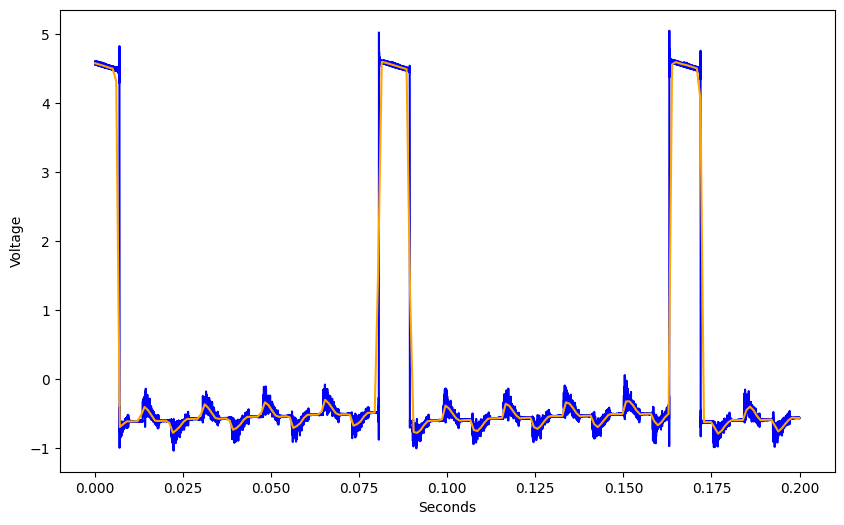

In [82]:
# plot 0,2s dos dados originais e reamostrados para comparação
# usado valor 10000 e 100, pois é 1/5 da taxa de amostragem original. pois esta sendo plotado 0,2s (1/5 de segundo)
time = 0.2 # s
qty_original_samples =  int(SAMPLE_RATE * time)
qty_resampled_sample = int(target_rate * time)
t1 = np.linspace(0, time, qty_original_samples)
t2 = np.linspace(0, time, qty_resampled_sample)
plt.figure(figsize=(10, 6))
plt.plot(t1,  normalSample[0][0:qty_original_samples], label='Sinal original', color='blue')
plt.plot(t2,  normalSampleResampled[0][0:qty_resampled_sample], label='Sinal resample', color='orange')
plt.xlabel('Seconds')
plt.ylabel('Voltage')

podemos observar que há perdas nos dados. Será testado diferentes frequencias de reamostragem para encontrar o melhor  trade-off entre a precisão dos dados e o custo de treinamento.

In [87]:
def fast_fourier_transform(x_acel):
    N = x_acel[0].shape[0]
    x_acel = x_acel - np.mean(x_acel)

    yf = rfft(x_acel)
    xf = rfftfreq(N, 1 / target_rate)

    plt.plot(xf, np.abs(yf))
    plt.title("Acceleration Spectrum")
    plt.show()

fast_fourier_transform(normalSampleResampled[0].values)

IndexError: tuple index out of range

modelos que podem ser usados
LSTM
dnn
knn
svm
